# Project Overview

Our Analytics team will collaborate with GreatYield to explore entry into the peer lending industry and investing in peer-to-peer loans through SoftLending. We will utilize various Data Science techniques to address critical questions and deliver a final data-driven decision.

**STEP 3** ⏳

In the previous step, the insights from our EDA affirmed the consistency of the data. In this report, we extend our previous ETL and EDA work, focusing on data preparation for modeling. We retracted the vast amount of graphs to make this file less crowded. It's worth noting that throughout this process, we utilized various external tools such as ChatGPT and Claude. Since a vast amount of the code was processed through AI for documentation purposes, we opted not to specify each instance where it was implemented. Additionally, we did not prioritize code optimization as it falls outside the scope of the grading criteria.






# **Pre-Processing**
### **Importing all the Libraries**

In [203]:
#Importing libraries required for the case study and to plot charts
import numpy as np # used for scientific computing
import pandas as pd # used for data analysis and manipulation
import matplotlib.pyplot as plt # used for visualization and plotting
import seaborn as sns
import re #Importing Regular Expressions for String manipulation
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
#from dataprep.eda import plot
from datetime import datetime
import datetime as dt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore') # Ignore warnings due to version problems
from sklearn import preprocessing
from google.colab import drive
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
!pip install category_encoders
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler





### **Helper Functions**

This snippet comprises functions that will be used throught the code for it to be cleaner:

In [204]:
# was used to identify if we can remove outliers as removed in box plots
def check_normal_distribution(df, feature_name, alpha=0.10):
    """
    Check if a feature in the DataFrame is approximately normally distributed.

    Parameters:
        df (DataFrame): The DataFrame containing the feature to be checked.
        feature_name (str): The name of the feature to be checked.
        alpha (float): The significance level for the Shapiro-Wilk test.
            Default is 0.05.

    Returns:
        str: A message indicating whether the feature is approximately normally distributed.
    """
    # Extract feature data
    feature_data = df[feature_name]

    # Shapiro-Wilk Test
    shapiro_test_statistic, shapiro_p_value = stats.shapiro(feature_data)

    # Check if p-value is greater than alpha
    if shapiro_p_value > alpha:
        # Plot histogram
        plt.hist(feature_data, bins='auto')
        plt.title(f'Histogram of {feature_name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

        # Plot Q-Q plot
        stats.probplot(feature_data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {feature_name}')
        plt.xlabel('Theoretical Quantiles')
        plt.ylabel('Ordered Values')
        plt.show()

        return f"The feature '{feature_name}' is approximately normally distributed (p-value={shapiro_p_value:.4f})"
    else:
        return f"The feature '{feature_name}' is not normally distributed (p-value={shapiro_p_value:.4f})"


# # Check normality of 'loan_amnt' feature
# print(check_normal_distribution(expired_2019, 'annual_inc'))



def percentile_trim(df, feature, threshold_low=0, threshold_high=100):
    """
    Percentile-based trimming for a specified feature in a DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - feature: Name of the feature/column to trim
    - threshold_low: Lower percentile threshold (default: 0)
    - threshold_high: Upper percentile threshold (default: 100)

    Returns:
    - Trimmed DataFrame
    """
    print(f'Before removing Outliers from {feature}:\n')
    print(df[feature].describe(),'\n')

    # Calculate percentile values for the specified feature
    low_percentile_value = df[feature].quantile(threshold_low / 100)
    high_percentile_value = df[feature].quantile(threshold_high / 100)

    # Trim instances based on the specified percentile thresholds
    trimmed_df = df[(df[feature] >= low_percentile_value) & (df[feature] <= high_percentile_value)]

    print(f'After removing outliers from {feature}:\n')
    print(trimmed_df[feature].describe())

    return trimmed_df

# Example usage:
# trimmed_df = percentile_trim(df, 'feature_name', threshold_low=5, threshold_high=95)


# Example usage:
# trimmed_df = percentile_trim(df, 'feature_name', threshold_low=5, threshold_high=95)

def remove_outliers_gaussian(df, feature, sigma=3, plot=True):
    # Calculate mean and standard deviation of the feature
    mean = df[feature].mean()
    std_dev = df[feature].std()

    # Define the lower and upper bounds for outliers removal
    lower_bound = mean - sigma * std_dev
    upper_bound = mean + sigma * std_dev

    # Create a mask to identify outliers using Gaussian kernel
    mask = np.abs(df[feature] - mean) <= sigma * std_dev

    # Filter the DataFrame to remove outliers
    df_filtered = df[mask]

    # Calculate number of instances removed
    instances_removed = len(df) - len(df_filtered)

    # Plot boxplots before and after outlier removal
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Boxplot before outlier removal
        sns.boxplot(y=feature, data=df, ax=axes[0])
        axes[0].set_title('Before Outlier Removal')

        # Boxplot after outlier removal
        sns.boxplot(y=feature, data=df_filtered, ax=axes[1])
        axes[1].set_title('After Outlier Removal')

        plt.tight_layout()
        plt.show()

    print(f"Number of instances removed: {instances_removed}")

    return df_filtered
# Example usage:
# Assuming df is your DataFrame and 'feature' is the column name
# filtered_df = remove_outliers_gaussian(df, 'feature')

def plot_distribution_with_log(df, feature):
    # Plot original distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature} (Original)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Plot distribution after log transformation
    plt.subplot(1, 2, 2)
    log_feature = np.log1p(df[feature])  # Apply log transformation
    sns.histplot(log_feature, kde=True)
    plt.title(f'Distribution of log({feature} + 1)')
    plt.xlabel(f'log({feature} + 1)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Formating the time columns to create active time col

def convert_date(month_year):
    if pd.isnull(month_year):
        return ''  # Return empty string for NaN values
    try:
        # Parse the input string into a datetime object
        date_obj = datetime.strptime(month_year, '%b-%y')
    except ValueError:
        return ''  # Return empty string for invalid date formats

    # Format the datetime object into the desired short date format
    short_date = date_obj.strftime('%d/%m/%Y')

    return short_date


# Function to compute VIF for each feature
def compute_vif(features, threshold=10):
    features = features.dropna()  # Drop rows containing NaN values
    vif_data = pd.DataFrame()
    vif_data["feature"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    redundant_features = vif_data[vif_data["VIF"] > threshold]["feature"]
    return redundant_features

#function for finding the best smoothing value (to prevent overfitting) for targeting encoding
def find_best_smoothing(df, cat_feature, target, param_grid, cv=5):
    best_score = -np.inf
    best_param = None
    for smoothing in param_grid:
        encoder = ce.TargetEncoder(cols=[cat_feature], smoothing=smoothing)
        df_encoded = df.copy()
        df_encoded[cat_feature + '_encoded'] = encoder.fit_transform(df[cat_feature], df[target])
        model = LogisticRegression(solver='liblinear')
        scores = cross_val_score(model, df_encoded[[cat_feature + '_encoded']], df[target], cv=cv, scoring='roc_auc')
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_param = smoothing
    return best_param, best_score

# Define the range of smoothing parameters to test
# param_grid = np.linspace(0.01, 0.1, 10)  # Example range of smoothing values

# Find the best smoothing parameter for the 'sub_grade' feature
# best_smoothing, best_score = find_best_smoothing(expired_2019, 'sub_grade', 'loan_status', param_grid)


def plot_feature_distributions(df):
    """
    Plots the distributions of all features in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the features to plot.
    """
    # Set up the matplotlib figure
    num_features = len(df.columns)
    num_rows = num_features // 2 + num_features % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 6))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(df[column]):
            # Continuous feature: use histogram and density plot
            sns.histplot(df[column], kde=True, ax=ax)
            ax.set_title(f'Histogram and Density Plot of {column}')
        elif pd.api.types.is_datetime64_any_dtype(df[column]):
            # Datetime feature: use line plot
            df[column].value_counts().sort_index().plot(ax=ax, kind='line')
            ax.set_title(f'Time Series Plot of {column}')
        elif pd.api.types.is_bool_dtype(df[column]):
            # Boolean feature: use count plot
            sns.countplot(x=df[column].astype(int), ax=ax)
            ax.set_title(f'Count Plot of {column}')
        elif pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_object_dtype(df[column]):
            if df[column].nunique() > 50:
                # Warn about high cardinality
                ax.text(0.5, 0.5, 'High cardinality\nFeature has too many categories',
                        horizontalalignment='center', verticalalignment='center', fontsize=12)
                ax.set_title(f'Bar Plot of {column} (High Cardinality)')
            else:
                # Categorical feature: use bar plot
                sns.countplot(y=df[column], ax=ax)
                ax.set_title(f'Bar Plot of {column}')
        else:
            # Mixed or unsupported type
            ax.text(0.5, 0.5, 'Unsupported data type',
                    horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax.set_title(f'{column}')

        ax.set_xlabel('')
        ax.set_ylabel('')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage:
# df = pd.read_csv('your_database.csv')
# plot_feature_distributions(df)

# **ETL**

### **Extracting Data**



We'll be focusing on "expired" loans from the snapshot of 2019 as we mentioned in the prior step.

In [205]:
#This code snippet may require modifications to the path and syntax if not executed in Google Colab.

#Mounting to google Drive
drive.mount('/content/drive' , force_remount=True)

# Store the path to apr 2019 snapshot CSV file
filepath = '/content/drive/My Drive/Analytics_Based_Project /loan-data-jul-2019-snap/'

q1_2019 = pd.read_csv(filepath + 'LoanStats_2016Q1.csv')
q2_2019 = pd.read_csv(filepath + 'LoanStats_2016Q2.csv')
q3_2019 = pd.read_csv(filepath + 'LoanStats_2016Q3.csv')
q4_2019 = pd.read_csv(filepath + 'LoanStats_2016Q4.csv')

Mounted at /content/drive


In [206]:

# Remove the title row from each quarterly file for 2019
# q2_2019 = q2_2019.iloc[1:]
# q3_2019 = q3_2019.iloc[1:]
# q4_2019 = q4_2019.iloc[1:]

# Concatenate the quarterly files for 2019 into a single dataframe
snap_2019 = pd.concat([q1_2019, q2_2019, q3_2019, q4_2019], axis=0)


In [207]:
# Creating a df for the expired loans
expired_2019 = snap_2019[(snap_2019['loan_status'] == 'Fully Paid') | (snap_2019['loan_status'] == 'Charged Off')]
print(len(expired_2019))


335003


In [208]:
# Percent of expired loans out of snap_2019
percantage = (len(expired_2019) / len(snap_2019)) * 100
print(f"The percantage of rows in expired_2019 out of the number of rows in snap_2019 is {percantage:.2f}%")


The percantage of rows in expired_2019 out of the number of rows in snap_2019 is 77.11%


We'll be extracting expired loans from 2018 too, only to test leakage among out features


In [209]:
#Mounting to google Drive
drive.mount('/content/drive' , force_remount=True)

# Store the path to apr 2019 snapshot CSV file
filepath = '/content/drive/My Drive/Analytics_Based_Project /loan-data-apr-2018-snap/'

q1_2018 = pd.read_csv(filepath + 'LoanStats_2016Q1.csv')
q2_2018 = pd.read_csv(filepath + 'LoanStats_2016Q2.csv')
q3_2018 = pd.read_csv(filepath + 'LoanStats_2016Q3.csv')
q4_2018 = pd.read_csv(filepath + 'LoanStats_2016Q4.csv')

Mounted at /content/drive


In [210]:
snap_2018 = pd.concat([q1_2018, q2_2018, q3_2018, q4_2018], axis=0) #sticking together the data frames rows under rows - axis=0
expired_2018 = snap_2018[(snap_2018['loan_status'] == 'Fully Paid') | (snap_2018['loan_status'] == 'Charged Off')] # only instances which in the loan status column- fully paidcharged off


### **Transformation**

### **Data Cleaning & Feature Selection**

Features and data types

In [211]:
# using a for loop print the tiltle of each column and its data type
count=0
for column_name in expired_2019.columns:
  print(f"- {column_name}, {expired_2019[column_name].dtype}")
  count+=1

print('----------------------------------------------')
print('numeber of columns =', count)

- id, object
- member_id, float64
- loan_amnt, float64
- funded_amnt, float64
- funded_amnt_inv, float64
- term, object
- int_rate, object
- installment, float64
- grade, object
- sub_grade, object
- emp_title, object
- emp_length, object
- home_ownership, object
- annual_inc, float64
- verification_status, object
- issue_d, object
- loan_status, object
- pymnt_plan, object
- url, object
- desc, object
- purpose, object
- title, object
- zip_code, object
- addr_state, object
- dti, float64
- delinq_2yrs, float64
- earliest_cr_line, object
- fico_range_low, float64
- fico_range_high, float64
- inq_last_6mths, float64
- mths_since_last_delinq, float64
- mths_since_last_record, float64
- open_acc, float64
- pub_rec, float64
- revol_bal, float64
- revol_util, object
- total_acc, float64
- initial_list_status, object
- out_prncp, float64
- out_prncp_inv, float64
- total_pymnt, float64
- total_pymnt_inv, float64
- total_rec_prncp, float64
- total_rec_int, float64
- total_rec_late_fee, float6

Plot of the Nan Values

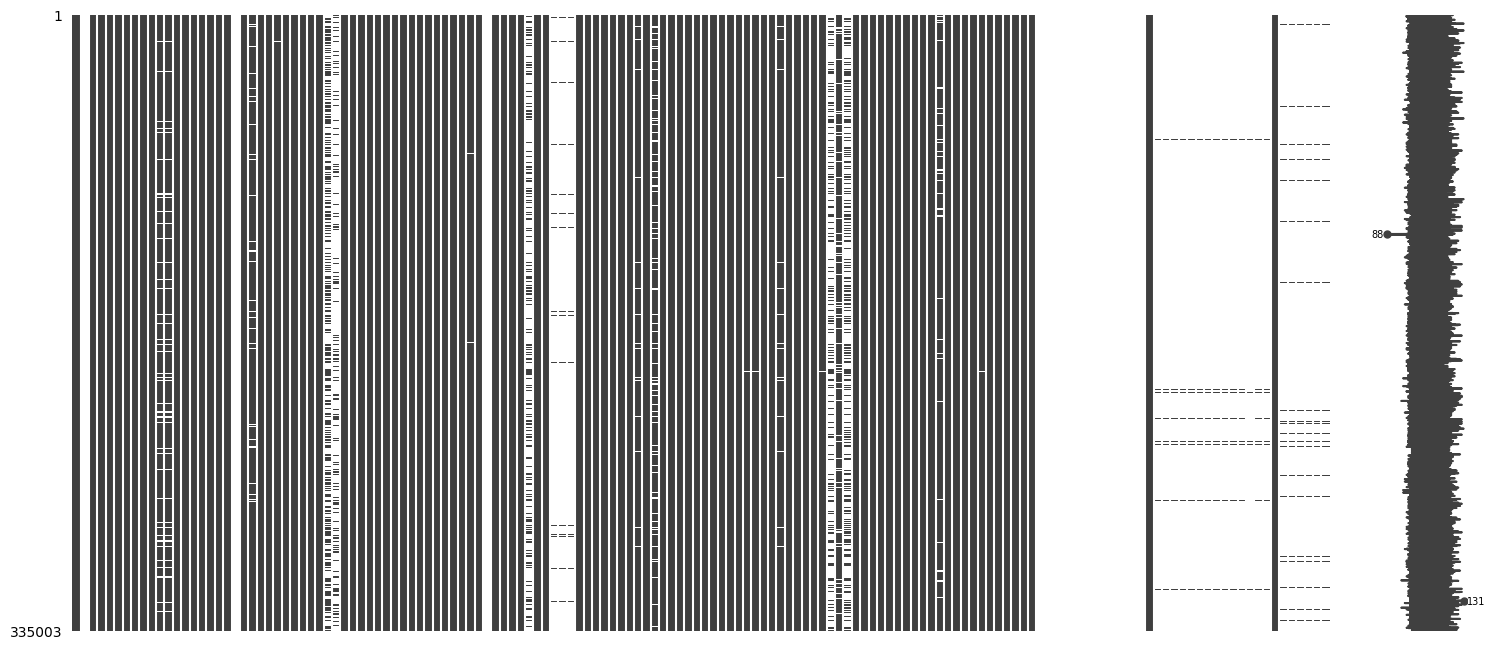

In [212]:

msno.matrix(expired_2019, labels=False, fontsize=8) #removed labels since they are too crowded
plt.gcf().set_size_inches(18, 8)
plt.show()


il_util is calculated by dividing the total current balance on installment loans by the total credit limit on all installment accounts and expressing the result as a percentage.

In [213]:
# Count the number of instances with missing il_util
missing_il_util_count = expired_2019['il_util'].isna().sum()

# Calculate il_util for instances with missing values
expired_2019.loc[expired_2019['il_util'].isna(), 'il_util'] = (expired_2019.loc[expired_2019['il_util'].isna(), 'total_bal_il'] / expired_2019.loc[expired_2019['il_util'].isna(), 'total_il_high_credit_limit']) * 100

# Count the number of instances with successfully completed il_util
completed_il_util_count = missing_il_util_count - expired_2019['il_util'].isna().sum()

# Print the number of instances with successfully completed il_util
print(f"Successfully completed il_util for {completed_il_util_count} instances.")


Successfully completed il_util for 10589 instances.


Removing features based On NAn treshold of 40% **(We double checked the removed features and no potentialy predictive/critical column that could have been recovered was removed)**

In [214]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Store the original column names
original_columns = expired_2019.columns.tolist()

# Drop all columns from expired_2019 that hold 40% or more NaN
removed_columns = expired_2019.columns[expired_2019.isnull().mean() >= 0.4].tolist()
expired_2019.dropna(thresh=int(expired_2019.shape[0] * 0.4), axis=1, inplace=True)

# Calculate the number of removed columns
# Print the columns that were removed and the number of columns removed
print("Columns removed ({}):".format(len(removed_columns)), removed_columns)

# expired_2019.head()


Columns removed (44): ['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', '

**Removing No Variance Columns**

In [215]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# printing uniue value features
cols_with_same_values = expired_2019.loc[:, expired_2019.nunique() == 1].columns

print("Columns with the same value in all rows:")
for column_name in cols_with_same_values:
    print(column_name)

# Drop columns that all the values are the same
expired_2019.drop(columns=expired_2019.loc[:, expired_2019.nunique() == 1].columns, inplace=True)


Columns with the same value in all rows:
pymnt_plan
out_prncp
out_prncp_inv
policy_code
hardship_flag


**Excluding Columns Based on Percent Change in Values Across 2018 and 2019- preventing data leakage**





In [216]:
# Merging 2018 and 2019 data frames on id, including only columns that exist in 2019
expired_both_years = pd.merge(expired_2019, expired_2018[expired_2019.columns], on='id', suffixes=('_19', '_18'))

# Percent change in rows for each feature (excluding id)
changed_features = {}
for column in expired_2019.columns:
    if column == 'id':  # Skip the 'id' column
        continue
    non_na_rows = expired_both_years[[f"{column}_18", f"{column}_19"]].dropna()
    changed_rows = (non_na_rows[f"{column}_18"] != non_na_rows[f"{column}_19"]).sum()
    percent_change = changed_rows / len(non_na_rows) * 100
    if percent_change > 0:
        changed_features[column] = percent_change

# Sorting and displaying results (some of the columns that changed where removed preliminary to this phase)
for feature, percent_change in sorted(changed_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {percent_change:.5f}% changed")


last_credit_pull_d: 61.36961% changed
last_fico_range_high: 56.99843% changed
last_fico_range_low: 56.99843% changed
total_pymnt: 7.95232% changed
total_pymnt_inv: 7.93559% changed
recoveries: 7.93559% changed
collection_recovery_fee: 7.93559% changed
verification_status: 1.30395% changed
debt_settlement_flag: 0.79298% changed
last_pymnt_amnt: 0.00461% changed
last_pymnt_d: 0.00289% changed
total_rec_int: 0.00288% changed
total_rec_prncp: 0.00115% changed
total_rec_late_fee: 0.00115% changed


before omitting the total_pymnt feature due to leakage, we'll calculate the expected return for each loan

In [217]:
def convert_date(month_year):
    if pd.isnull(month_year):
        return ''  # Return empty string for NaN values
    try:
        # Parse the input string into a datetime object
        date_obj = datetime.strptime(month_year, '%b-%y')
    except ValueError:
        return ''  # Return empty string for invalid date formats

    # Format the datetime object into the desired short date format
    short_date = date_obj.strftime('%d/%m/%Y')

    return short_date

# Convert 'last_pymnt_d' and 'issue_d' to datetime format
expired_2019['last_pymnt_d'] = expired_2019['last_pymnt_d'].astype(str).apply(convert_date)
expired_2019['issue_d'] = expired_2019['issue_d'].astype(str).apply(convert_date)

# Convert the dates to datetime objects
expired_2019['last_pymnt_d'] = pd.to_datetime(expired_2019['last_pymnt_d'], format='%d/%m/%Y', errors='coerce')
expired_2019['issue_d'] = pd.to_datetime(expired_2019['issue_d'], format='%d/%m/%Y', errors='coerce')

# Calculate the 'Total_Months_Active'
expired_2019['Total_Months_Active'] = (expired_2019['last_pymnt_d'] - expired_2019['issue_d']).dt.days // 30

# Ensure no NaN values in 'Total_Months_Active'
expired_2019['Total_Months_Active'] = expired_2019['Total_Months_Active'].fillna(0).astype(int)

print(expired_2019[['last_pymnt_d', 'issue_d', 'Total_Months_Active']].head())

# Calculate the expected return
p = expired_2019['total_pymnt']
f = expired_2019['loan_amnt']
m = expired_2019['Total_Months_Active']

# Ensure no division by zero and handle NaNs
m = m.replace(0, np.nan)
expired_2019['expected_return'] = (p - f) / f * (12 / m)

# Check for NaN values in 'expected_return'
print(f"Number of NaN values in 'expected_return': {expired_2019['expected_return'].isna().sum()}")

# Remove rows with NaN values in 'expected_return'
expired_2019 = expired_2019.dropna(subset=['expected_return'])

# Verify removal
print(f"Number of rows after removing NaNs: {expired_2019.shape[0]}")
print(expired_2019[['funded_amnt', 'loan_amnt', 'Total_Months_Active', 'expected_return']].head())


  last_pymnt_d    issue_d  Total_Months_Active
0   2017-03-01 2016-03-01                   12
2   2019-03-01 2016-03-01                   36
3   2019-04-01 2016-03-01                   37
4   2018-04-01 2016-03-01                   25
5   2017-11-01 2016-03-01                   20
Number of NaN values in 'expected_return': 3525
Number of rows after removing NaNs: 331478
   funded_amnt  loan_amnt  Total_Months_Active  expected_return
0       9000.0     9000.0                   12         0.132628
2       8000.0     8000.0                   36         0.059215
3      12800.0    12800.0                   37         0.063086
4       5000.0     5000.0                   25        -0.055841
5      24000.0    24000.0                   20        -0.191358


Binary column for expected return above 2%




In [218]:
expired_2019['yield_is_above_2'] = expired_2019['expected_return'].apply(lambda x: 0 if x > 0.02 else 1)
expired_2019

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,Total_Months_Active,expected_return,yield_is_above_2
0,76143686,9000.0,9000.0,9000.0,36 months,15.31%,313.36,C,C5,Senior Case Assistant,...,0.0,0.0,58425.0,52953.0,15900.0,42525.0,N,12,0.132628,0
2,76143234,8000.0,8000.0,8000.0,36 months,10.75%,260.97,B,B4,Vp,...,0.0,0.0,78840.0,62125.0,22000.0,56040.0,N,36,0.059215,0
3,75710736,12800.0,12800.0,12800.0,36 months,11.99%,425.09,C,C1,LOGISTICS COORDINATOR,...,1.0,0.0,235600.0,32004.0,7900.0,34024.0,N,37,0.063086,0
4,75858516,5000.0,5000.0,5000.0,36 months,16.29%,176.51,D,D1,Investigator,...,0.0,0.0,496358.0,102537.0,5600.0,94567.0,N,25,-0.055841,1
5,76042301,24000.0,24000.0,24000.0,36 months,9.75%,771.60,B,B3,C&C MACHINE OPERATOR,...,0.0,0.0,113715.0,46058.0,20000.0,36715.0,N,20,-0.191358,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103538,89996426,32000.0,32000.0,32000.0,60 months,14.49%,752.74,C,C4,Sales Manager,...,0.0,0.0,524379.0,122872.0,15800.0,23879.0,N,5,-2.119655,1
103539,90006534,16000.0,16000.0,16000.0,60 months,12.79%,362.34,C,C1,Manager,...,3.0,0.0,87473.0,65797.0,10100.0,73473.0,N,17,0.117380,0
103541,89885898,24000.0,24000.0,24000.0,60 months,12.79%,543.50,C,C1,Unit Operator,...,0.0,0.0,102517.0,104422.0,0.0,52017.0,N,31,0.103939,0
103543,88985880,40000.0,40000.0,40000.0,60 months,10.49%,859.56,B,B3,Vice President,...,0.0,0.0,55970.0,28398.0,12300.0,42670.0,N,30,0.083694,0


adding the risk factor to each loan's exected return by the standard deviation of the grade's expected return avergae


In [219]:
grouped = expired_2019.groupby('grade')['expected_return']
mean_returns = grouped.mean()
std_devs = grouped.std()

print("Mean Expected Returns by Grade:")
print(mean_returns)
print("\nStandard Deviations by Grade:")
print(std_devs)

# Function to adjust expected return of each loan by adding standard deviation based on grade
def adjust_return(row, std_dev_dict):
    std_dev = std_dev_dict.get(row['grade'], 0)  # Default to 0 if grade not found
    return row['expected_return'] + std_dev  # Add the standard deviation to the expected return

# Apply the adjustment to each row in the DataFrame
expired_2019['expected_return'] = expired_2019.apply(adjust_return, axis=1, args=(std_devs,))

# Display the adjusted returns
print(expired_2019[['grade', 'expected_return']].head())

Mean Expected Returns by Grade:
grade
A    0.005632
B   -0.031047
C   -0.099302
D   -0.181423
E   -0.280065
F   -0.409530
G   -0.555280
Name: expected_return, dtype: float64

Standard Deviations by Grade:
grade
A    0.302688
B    0.492009
C    0.707878
D    0.895186
E    1.073006
F    1.227138
G    1.498214
Name: expected_return, dtype: float64
  grade  expected_return
0     C         0.840506
2     B         0.551224
3     C         0.770965
4     D         0.839345
5     B         0.300651


In [220]:
# removing last_pymnt_d since it will be used to calculate moths active and emp_length , albeit it changed we dont see it as leakage
changed_features.pop('last_pymnt_d','emp_length')
# Drop from expired_2019 df the keys of dictionary changed_features
expired_2019.drop(list(changed_features.keys()), axis=1, inplace=True)

# Print the names of the dropped columns
print("The following columns were dropped:")
for column in list(changed_features.keys()):
    print(column)




The following columns were dropped:
verification_status
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
last_credit_pull_d
last_fico_range_high
last_fico_range_low
debt_settlement_flag




**post-loan features + data understanding (irrelevant for our analysis)**








In [221]:
# omitting features based on data understanding and leakage
omit_features = ['id','url','title','zip_code', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'inq_last_12m','acc_now_delinq','tot_coll_amt','tot_cur_bal','collections_12_mths_ex_med','mths_since_last_delinq','chargeoff_within_12_mths',
'funded_amnt_inv', 'mths_since_recent_bc','mths_since_recent_inq','inq_last_6mths','mths_since_rcnt_il','mo_sin_old_il_acct','num_tl_120dpd_2m','percent_bc_gt_75']
expired_2019.drop(omit_features, axis=1, inplace=True)



**High Correlation Analysis**

This code identifies highly correlated numeric columns in the DataFrame expired_2019 and selects one feature from each group to reduce redundancy and multicollinearity. By keeping only one feature from each correlated group, we maintain data integrity while improving model interpretability and performance. (we might keep the 0.89-0.95 )



**Features we decided to keep**

1. 'loan_amnt': Directly represents the principal amount borrowed, crucial for lending decisions.

2. 'fico_range_low': Represents the lower end of the FICO credit score range, providing a conservative estimate of creditworthiness.

3. 'open_acc': Commonly used and understood, represents the number of open credit accounts.

4. The more conservative option would be to choose 'total_bal_ex_mort' as it excludes mortgage balances, potentially providing a clearer picture of the borrower's financial situation.

5. 'total_bal_il': Represents the total current balance of all installment accounts, providing comprehensive financial information.

6. 'num_actv_rev_tl': Represents the number of currently active revolving credit accounts, essential for assessing credit activity.

In [222]:
# prompt: rint all column groups/pairs in expired_2019 that hold more than 0.9 correlation , make sure you are comparing the correct data types


# Filter only numeric columns
numeric_cols = expired_2019.select_dtypes(include='number').columns

# Initialize list to store correlated groups
correlated_groups = []

# Iterate over numeric columns
for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:
        # Compute correlation
        corr = expired_2019[col1].corr(expired_2019[col2])
        # Check if correlation exceeds threshold
        if abs(corr) >= 0.899:
            # Append correlated groups to list
            correlated_groups.append((col1, col2))

# Print correlated groups and their correlation values
for group in correlated_groups:
    corr_value = expired_2019[group[0]].corr(expired_2019[group[1]])
    print(f"Columns '{group[0]}' and '{group[1]}' are correlated with a value of {corr_value}")

print('--------------------------')

features_to_drop = [
    'installment',  # From 'loan_amnt' and 'installment' group
    'fico_range_high',  # From 'fico_range_low' and 'fico_range_high' group
    'num_sats',  # From 'open_acc' and 'num_sats' group
    'total_bal_ex_mort',  # From 'total_bal_il' and 'total_bal_ex_mort' group
    'total_il_high_credit_limit',  # From 'total_bal_il' and 'total_il_high_credit_limit' group
    'num_rev_tl_bal_gt_0',  # From 'num_actv_rev_tl' and 'num_rev_tl_bal_gt_0' group
    'total_bal_il' # conservative approach
]

# Drop the features from expired_2019 DataFrame
expired_2019.drop(columns=features_to_drop, inplace=True)

# Print the names of the dropped features
print("Features removed due to high correlation:")
for feature in features_to_drop:
    print(feature)

Columns 'loan_amnt' and 'funded_amnt' are correlated with a value of 0.9999987795764304
Columns 'loan_amnt' and 'installment' are correlated with a value of 0.9605759709844094
Columns 'funded_amnt' and 'installment' are correlated with a value of 0.9605769207335342
Columns 'fico_range_low' and 'fico_range_high' are correlated with a value of 0.9999999098269748
Columns 'open_acc' and 'num_sats' are correlated with a value of 0.9986677754586957
Columns 'total_bal_il' and 'total_il_high_credit_limit' are correlated with a value of 0.9588577342650355
Columns 'num_actv_rev_tl' and 'num_rev_tl_bal_gt_0' are correlated with a value of 0.9776042333947869
--------------------------
Features removed due to high correlation:
installment
fico_range_high
num_sats
total_bal_ex_mort
total_il_high_credit_limit
num_rev_tl_bal_gt_0
total_bal_il


In [223]:
# number and names of the remianing features

count = 1
for column_name in expired_2019.columns:
  print(f"{count}- {column_name}")
  count+=1


1- loan_amnt
2- funded_amnt
3- term
4- int_rate
5- grade
6- sub_grade
7- emp_title
8- emp_length
9- home_ownership
10- annual_inc
11- issue_d
12- loan_status
13- purpose
14- addr_state
15- dti
16- delinq_2yrs
17- earliest_cr_line
18- fico_range_low
19- open_acc
20- pub_rec
21- revol_bal
22- revol_util
23- total_acc
24- initial_list_status
25- last_pymnt_d
26- application_type
27- open_act_il
28- il_util
29- max_bal_bc
30- all_util
31- total_rev_hi_lim
32- total_cu_tl
33- acc_open_past_24mths
34- avg_cur_bal
35- bc_open_to_buy
36- bc_util
37- delinq_amnt
38- mo_sin_old_rev_tl_op
39- mo_sin_rcnt_rev_tl_op
40- mo_sin_rcnt_tl
41- mort_acc
42- num_accts_ever_120_pd
43- num_actv_bc_tl
44- num_actv_rev_tl
45- num_bc_sats
46- num_bc_tl
47- num_il_tl
48- num_op_rev_tl
49- num_rev_accts
50- num_tl_30dpd
51- num_tl_90g_dpd_24m
52- num_tl_op_past_12m
53- pct_tl_nvr_dlq
54- pub_rec_bankruptcies
55- tax_liens
56- tot_hi_cred_lim
57- total_bc_limit
58- Total_Months_Active
59- expected_return
60- yiel

In [224]:
# omitting from expired_2019 instances that has empty value in emp_title  and  do not! have nan value in emp_length column, thus there is contradiction.
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Select instances that have empty emp_title and non-NaN emp_length
instances_to_omit = expired_2019[expired_2019['emp_title'].isna() & ~expired_2019['emp_length'].isna()]

# Print the number of instances to be omitted
print(f"Number of instances to be omitted: {len(instances_to_omit)}")

# Remove the selected instances from expired_2019
expired_2019 = expired_2019.drop(instances_to_omit.index)


# Replace missing values in emp_title with 'unemployed'
expired_2019['emp_title'].fillna('unemployed', inplace=True)

# Replace missing values in emp_length with 0
expired_2019['emp_length'].fillna("0 years", inplace=True)

# create a new column named emp_status 1 for employed 0 for unemployed

expired_2019.insert(loc=8, column='emp_status', value=np.where(expired_2019['emp_title'].isin(['unemployed']), 0, 1))


print(expired_2019['emp_status'].unique())

print(expired_2019[['emp_title', 'emp_length', 'emp_status']].head(20))




Number of instances to be omitted: 368
[1 0]
                      emp_title emp_length  emp_status
0         Senior Case Assistant    9 years           1
2                            Vp    5 years           1
3         LOGISTICS COORDINATOR    6 years           1
4                  Investigator  10+ years           1
5          C&C MACHINE OPERATOR    5 years           1
6                       Manager    2 years           1
7                         agent  10+ years           1
8        Branch account manager     1 year           1
10            Project Scientist     1 year           1
11                   unemployed    0 years           0
12                          CEO     1 year           1
13             Terminal Manager    8 years           1
14     Patient Services Manager    5 years           1
15                       Cantor  10+ years           1
16        Firefighter Paramedic  10+ years           1
18                      Teacher  10+ years           1
19                  

In [225]:
# prompt: omit the emp_title column

expired_2019.drop(columns=['emp_title'], axis=1, inplace=True)


**data-structure checkpoint**

In [226]:
print(f"Number of remaining instances: {len(expired_2019)}")
print("Remaining features:")
count = 1
for column_name in expired_2019.columns:
  print(f"{count}- {column_name}")
  count+=1


Number of remaining instances: 330350
Remaining features:
1- loan_amnt
2- funded_amnt
3- term
4- int_rate
5- grade
6- sub_grade
7- emp_length
8- emp_status
9- home_ownership
10- annual_inc
11- issue_d
12- loan_status
13- purpose
14- addr_state
15- dti
16- delinq_2yrs
17- earliest_cr_line
18- fico_range_low
19- open_acc
20- pub_rec
21- revol_bal
22- revol_util
23- total_acc
24- initial_list_status
25- last_pymnt_d
26- application_type
27- open_act_il
28- il_util
29- max_bal_bc
30- all_util
31- total_rev_hi_lim
32- total_cu_tl
33- acc_open_past_24mths
34- avg_cur_bal
35- bc_open_to_buy
36- bc_util
37- delinq_amnt
38- mo_sin_old_rev_tl_op
39- mo_sin_rcnt_rev_tl_op
40- mo_sin_rcnt_tl
41- mort_acc
42- num_accts_ever_120_pd
43- num_actv_bc_tl
44- num_actv_rev_tl
45- num_bc_sats
46- num_bc_tl
47- num_il_tl
48- num_op_rev_tl
49- num_rev_accts
50- num_tl_30dpd
51- num_tl_90g_dpd_24m
52- num_tl_op_past_12m
53- pct_tl_nvr_dlq
54- pub_rec_bankruptcies
55- tax_liens
56- tot_hi_cred_lim
57- total_bc

### **In this section we'll focus on the instances we want to alter or disregard**

In [227]:
# prompt: please print instaces that have na in the expected return column, and print the number of omitted instances

# Select instances with NaN in 'expected_return'
omitted_instances = expired_2019[expired_2019['expected_return'].isna()]

# Print the number of omitted instances
print(f"Number of omitted instances: {len(omitted_instances)}")

# Print the omitted instances
print(len(omitted_instances))


Number of omitted instances: 0
0


**Checking for Duplicates**



In [228]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# print the number of duplicates on expired_2019

print('Number of duplicates:', expired_2019.duplicated().sum())


Number of duplicates: 0


**Removing loans that are missing critical features**


In [229]:

# Define your dataframe expired_2019 and critical_features
critical_features = critical_features = [
    'loan_status', 'annual_inc', 'dti', 'earliest_cr_line', 'loan_amnt', 'int_rate', 'purpose',
     'emp_length', 'home_ownership', 'addr_state','last_pymnt_d','issue_d', 'yield_is_above_2', 'expected_return', 'grade'
]

# Count instances before removal
instances_before_removal = len(expired_2019)

# Check for NaN values in critical features and remove corresponding instances
expired_2019_cleaned = expired_2019.dropna(subset=critical_features)

# Count instances after removal
instances_after_removal = len(expired_2019_cleaned)

# Calculate the number of removed instances
removed_instances = instances_before_removal - instances_after_removal

# Update expired_2019 with cleaned data
expired_2019 = expired_2019_cleaned.copy()

# Print the count of removed instances
print(f"Removed {removed_instances} instances due to missing values in critical features.")


Removed 46 instances due to missing values in critical features.


**Removing instances with multiple nans (needs to be reviewed)**


In [230]:
# this code  drops the instances with 3 or more nans and the prints the number of instances removed from expired_2019 we are still devating if this apprach is too aggresive

# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Count instances before removal
instances_before_removal = len(expired_2019)

# Drop instances with 5 or more NaN values
expired_2019 = expired_2019.dropna(thresh=len(expired_2019.columns) - 3)

# Count instances after removal
instances_after_removal = len(expired_2019)

# Calculate the number of removed instances
removed_instances = instances_before_removal - instances_after_removal

# Print the count of removed instances
print(f"Removed {removed_instances} instances with 3 or more NaN values.")


Removed 71 instances with 3 or more NaN values.


To simplify our analysis, we've chosen to temporarily **exclude joint loan** applications. They represent only a small fraction of the total loans, and their secondary features might affect the analysis of other loans. ( We might do a separate analysis on joint loans in the feature.)

In [231]:
# This snippet prints the percantage of 'Individual' and 'Joint App' in application_type , then drop all instances that hold in 'application_type 'Joint App' and lasttly drop the application_type column

# Calculate the percentage of 'Individual' and 'Joint App' in application_type
application_type_counts = expired_2019['application_type'].value_counts()
individual_percentage = (application_type_counts['Individual'] / application_type_counts.sum()) * 100
joint_percentage = (application_type_counts['Joint App'] / application_type_counts.sum()) * 100

# Print the percentage
print(f"Percentage of 'Joint App': {joint_percentage:.2f}%")

# Drop all instances that have 'Joint App' in 'application_type'
expired_2019= expired_2019[expired_2019['application_type'] != 'Joint App']

# Drop the application_type column
expired_2019.drop(columns=['application_type'], inplace=True)
application_type_counts


Percentage of 'Joint App': 1.80%


application_type
Individual    324281
Joint App       5952
Name: count, dtype: int64

 features with the highest Nan %

In [232]:
# Calculate the percentage of NaN values in each column
nan_percentages = expired_2019.isna().mean() * 100

# Check if there are any NaNs in the DataFrame
if nan_percentages.any():
    # Sort the percentages in descending order
    sorted_nan_percentages = nan_percentages.sort_values(ascending=False)

    # Determine the number of columns that correspond to the top 10%
    top_10_percent_count = max(1, int(len(sorted_nan_percentages) * 0.1))

    # Select the top 10% of the highest percentages
    top_nan_percentages = sorted_nan_percentages.head(top_10_percent_count)

    # Print the top 10% highest percentages
    print(top_nan_percentages)
else:
    print("No NaN values in any column.")


il_util           9.997194
bc_util           1.117549
bc_open_to_buy    1.068826
revol_util        0.056741
all_util          0.000617
dtype: float64


In [233]:
# prompt: please print number of remaining instances in expired 2019 data frame, and below print "remaining features" and
# the names of the remaning features in expired_2019 using for loop with indexing starting from 1.

print(f"Number of remaining instances: {len(expired_2019)}")
print("Remaining features:")
count = 1
for column_name in expired_2019.columns:
  print(f"{count}- {column_name}")
  count+=1


Number of remaining instances: 324281
Remaining features:
1- loan_amnt
2- funded_amnt
3- term
4- int_rate
5- grade
6- sub_grade
7- emp_length
8- emp_status
9- home_ownership
10- annual_inc
11- issue_d
12- loan_status
13- purpose
14- addr_state
15- dti
16- delinq_2yrs
17- earliest_cr_line
18- fico_range_low
19- open_acc
20- pub_rec
21- revol_bal
22- revol_util
23- total_acc
24- initial_list_status
25- last_pymnt_d
26- open_act_il
27- il_util
28- max_bal_bc
29- all_util
30- total_rev_hi_lim
31- total_cu_tl
32- acc_open_past_24mths
33- avg_cur_bal
34- bc_open_to_buy
35- bc_util
36- delinq_amnt
37- mo_sin_old_rev_tl_op
38- mo_sin_rcnt_rev_tl_op
39- mo_sin_rcnt_tl
40- mort_acc
41- num_accts_ever_120_pd
42- num_actv_bc_tl
43- num_actv_rev_tl
44- num_bc_sats
45- num_bc_tl
46- num_il_tl
47- num_op_rev_tl
48- num_rev_accts
49- num_tl_30dpd
50- num_tl_90g_dpd_24m
51- num_tl_op_past_12m
52- pct_tl_nvr_dlq
53- pub_rec_bankruptcies
54- tax_liens
55- tot_hi_cred_lim
56- total_bc_limit
57- Total_Mont

### ***Handeling NAs***

***A Conservative and Simplistic Approach to Imputing NaN Values: Median vs. Mean***


***Median Imputation:***

- Skewness of the Data: If the data is skewed (either left or right skewed), the median is a better measure of central tendency because it is not affected by extreme values (outliers).
- Presence of Outliers: If there are significant outliers in the data, the median is less affected by them and provides a more robust measure of central tendency.

***Mean Imputation:***

- Skewness of the Data: If the data is approximately normally distributed (symmetrical), the mean can be a suitable measure because it utilizes all the data points.
- Presence of Outliers: If outliers are not a concern and the data is uniformly distributed, the mean can be used.

The **"il_util"** feature indicates a borrower's account utilization, crucial for assessing loan repayment ability.The distribution of "il_util" is non-normal, with a median greater than the mean, so we'll use the median to fill in missing values conservatively.

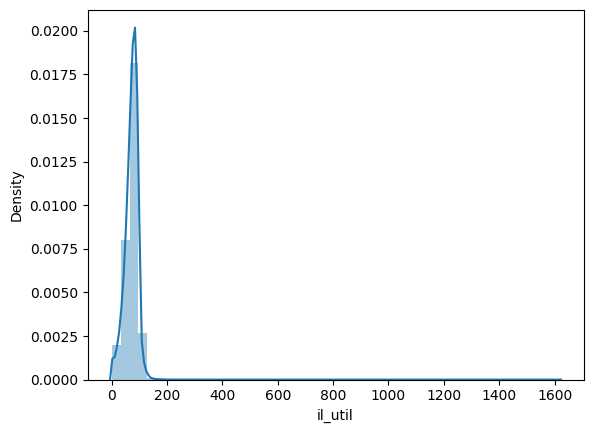

Median of il_util: 75.0
Mean of il_util: 71.8428848720521


In [234]:


sns.distplot(expired_2019['il_util'])
plt.show()

print(f"Median of il_util: {expired_2019['il_util'].median()}")
print(f"Mean of il_util: {expired_2019['il_util'].mean()}")


Implementation of the NAn imputation of util_il with the median

In [235]:

nan_count_before = expired_2019['il_util'].isna().sum()
# Replace NaN values in il_util with the median
expired_2019['il_util'].fillna(expired_2019['il_util'].median(), inplace=True)

# Count the number of NaN values replaced with the median
nan_count_after = expired_2019['il_util'].isna().sum()
replaced_count = nan_count_before - nan_count_after

# Print the number of replaced NaN values
print(f"Replaced {replaced_count} NaN values with the median in il_util.")


Replaced 32419 NaN values with the median in il_util.


**bc_util** refers to "bankcard utilization," which is a measure of how much of a borrower's available bankcard (credit card) credit they are currently using. It is usually expressed as a percentage.



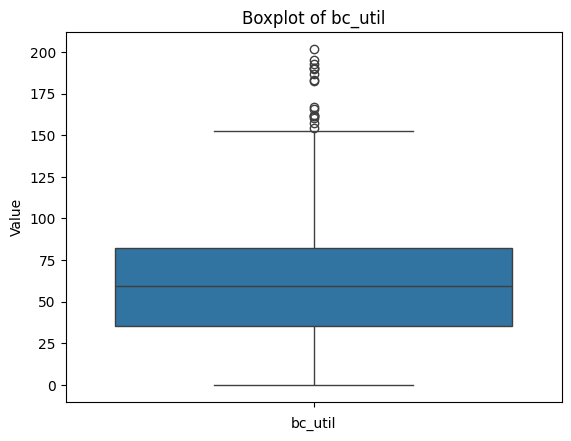

Median of bc_util: 59.5
Mean of bc_util: 57.60312514618423


In [236]:
# box plot of the feature bc_util

sns.boxplot(expired_2019['bc_util'])
plt.xlabel('bc_util')
plt.ylabel('Value')
plt.title('Boxplot of bc_util')
plt.show()

print(f"Median of bc_util: {expired_2019['bc_util'].median()}")
print(f"Mean of bc_util: {expired_2019['bc_util'].mean()}")

Even thougth after observating the distribution of **bc_util** we can see its close to normal we'll prefer to impute the NAs with the  median since there is a precence of outliers (making the median to surpass the mean)

In [237]:
nan_count_before = expired_2019['bc_util'].isna().sum()
# Replace NaN values in bc_util with the median
expired_2019['bc_util'].fillna(expired_2019['bc_util'].median(), inplace=True)

# Count the number of NaN values replaced with the median
nan_count_after = expired_2019['bc_util'].isna().sum()
replaced_count = nan_count_before - nan_count_after

# Print the number of replaced NaN values
print(f"Replaced {replaced_count} NaN values with the median in bc_util.")



Replaced 3624 NaN values with the median in bc_util.


**bc_open_to_buy** refers to the "bankcard open to buy," which indicates the amount of available credit that a borrower has on their bankcards (credit cards). This metric represents the difference between the credit limit and the current balance, effectively showing how much credit is still available to the borrower for use. We'll adress it with the same treatement

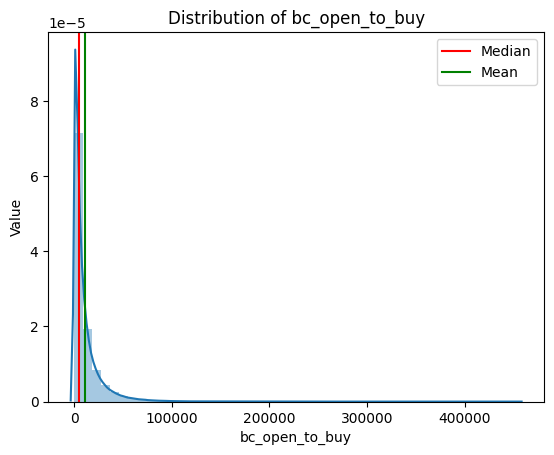

In [238]:

sns.distplot(expired_2019['bc_open_to_buy'])
plt.xlabel('bc_open_to_buy')
plt.ylabel('Value')
plt.title('Distribution of bc_open_to_buy')
plt.axvline(x=expired_2019['bc_open_to_buy'].median(), color='red', label='Median')
plt.axvline(x=expired_2019['bc_open_to_buy'].mean(), color='green', label='Mean')
plt.legend()
plt.show()


In [239]:
# stat info of bc_open_to_buy
expired_2019['bc_open_to_buy'].describe()


count    320815.000000
mean      10717.794785
std       15563.486098
min           0.000000
25%        1756.000000
50%        5300.000000
75%       13193.000000
max      454843.000000
Name: bc_open_to_buy, dtype: float64

In [240]:
nan_count_before = expired_2019['bc_open_to_buy'].isna().sum()
# Replace NaN values in bc_open_to_buy with the median
expired_2019['bc_open_to_buy'].fillna(expired_2019['bc_open_to_buy'].median(), inplace=True)

# Count the number of NaN values replaced with the median
nan_count_after = expired_2019['bc_open_to_buy'].isna().sum()
replaced_count = nan_count_before - nan_count_after

# Print the number of replaced NaN values
print(f"Replaced {replaced_count} NaN values with the median in bc_open_to_buy.")

Replaced 3466 NaN values with the median in bc_open_to_buy.


**revol_util** refers to "revolving credit utilization," which is similar to bankcard utilization but encompasses all types of revolving credit accounts, not just credit cards. Firstly we'll adjust the data format of the feature and then we'll delve into its distribution.

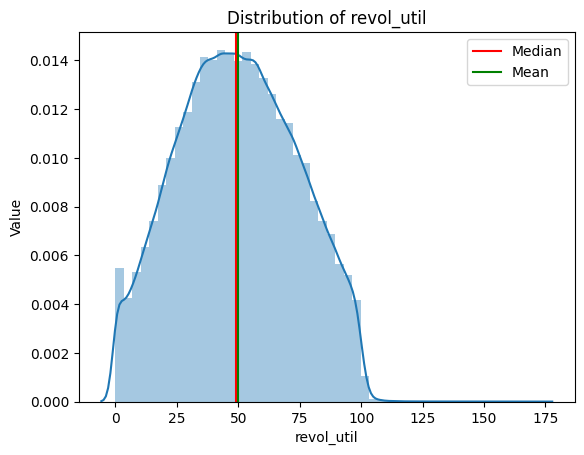

In [241]:
# prompt: plot the distribution of revol_util

# Removing the '%' sign from the revol_util column and changing the data type to double
expired_2019['revol_util'] = expired_2019['revol_util'].str.replace('%', '')
expired_2019['revol_util'] = expired_2019['revol_util'].astype(float)

sns.distplot(expired_2019['revol_util'])
plt.xlabel('revol_util')
plt.ylabel('Value')
plt.title('Distribution of revol_util')
plt.axvline(x=expired_2019['revol_util'].median(), color='red', label='Median')
plt.axvline(x=expired_2019['revol_util'].mean(), color='green', label='Mean')
plt.legend()
plt.show()


Since the distribution is almost normal, in this case we'll fill the na's with the mean of revol_util

In [242]:
nan_count_before = expired_2019['revol_util'].isna().sum()
# Replace NaN values in revol_util with the mean
expired_2019['revol_util'].fillna(expired_2019['revol_util'].mean(), inplace=True)

# Count the number of NaN values replaced with the mean
nan_count_after = expired_2019['revol_util'].isna().sum()
replaced_count = nan_count_before - nan_count_after

# Print the number of replaced NaN values
print(f"Replaced {replaced_count} NaN values with the mean in revol_util.")

Replaced 184 NaN values with the mean in revol_util.


<Axes: >

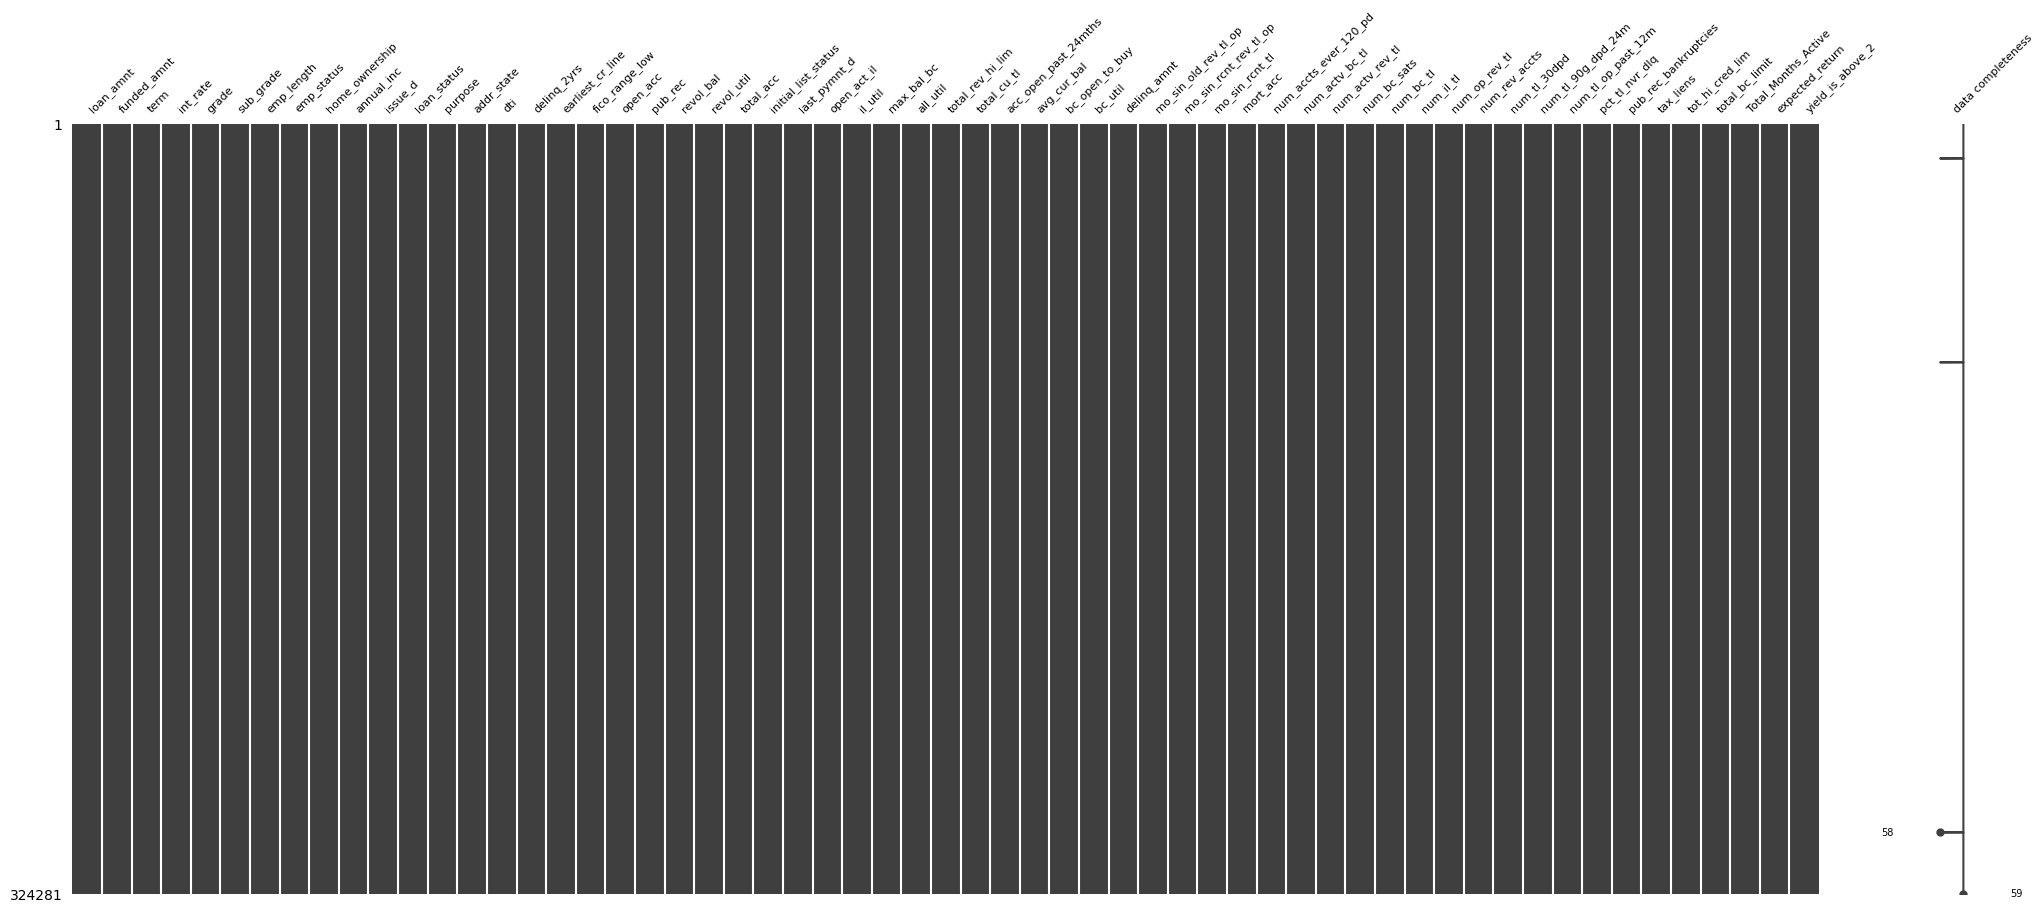

In [243]:
# NAn plot after cleansing
msno.matrix(expired_2019, labels=True, fontsize=8)

### features' values distribution

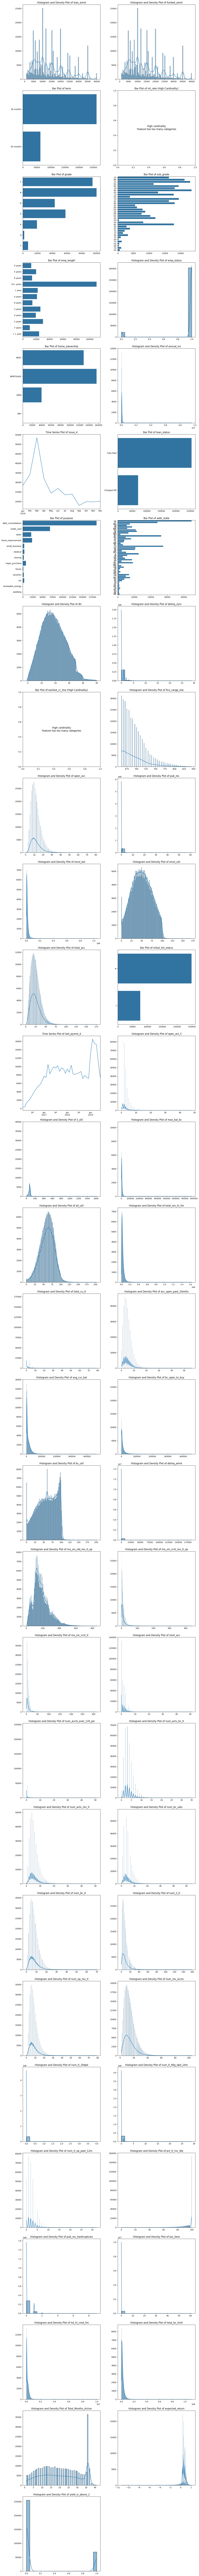

In [244]:
plot_feature_distributions(expired_2019)

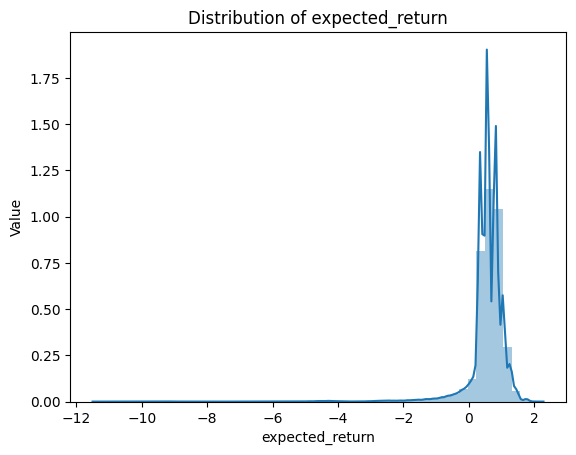

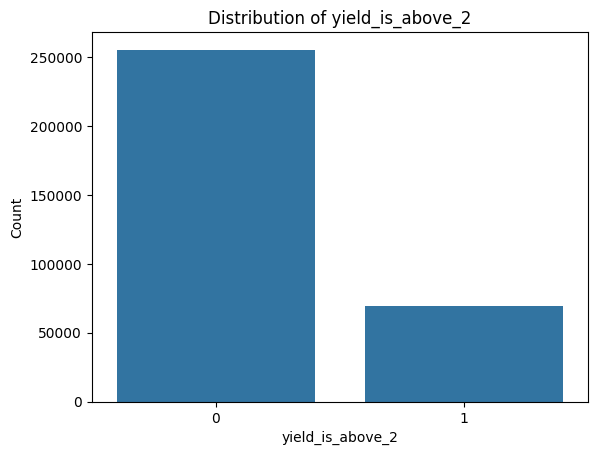

In [245]:

sns.distplot(expired_2019['expected_return'])
plt.xlabel('expected_return')
plt.ylabel('Value')
plt.title('Distribution of expected_return')
plt.show()

sns.barplot(x = expired_2019['yield_is_above_2'].value_counts().index, y = expired_2019['yield_is_above_2'].value_counts().values)
plt.xlabel('yield_is_above_2')
plt.ylabel('Count')
plt.title('Distribution of yield_is_above_2')
plt.show()


### **Formating Data**

Changing the loan status to be numeric

In [246]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Take the loan_status column and change the values from 'Charged Off' to be 1 and  to be 0 'Fully Paid'.
#print(expired_2019['loan_status'].head())
expired_2019['loan_status'] = expired_2019['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
#print(expired_2019['loan_status'].type())

In [247]:
# # !pip install dataprep
# from dataprep.eda import plot
# plot(expired_2019)

**purpose attribute formating**

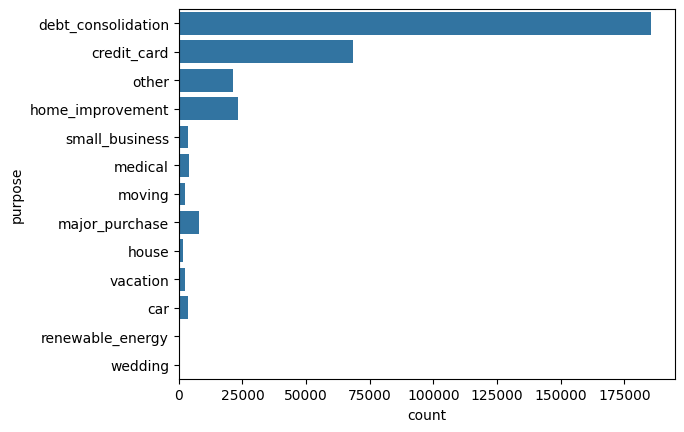

               purpose  percentage
0   debt_consolidation   57.201316
1          credit_card   21.082025
2     home_improvement    7.183585
3                other    6.576395
4       major_purchase    2.413956
5              medical    1.240282
6                  car    1.117241
7       small_business    1.104289
8               moving    0.775870
9             vacation    0.766619
10               house    0.469654
11    renewable_energy    0.068459
12             wedding    0.000308


In [248]:
#  computing the percentage of each purpose and performing the distribution of it
sns.countplot(expired_2019['purpose'])
plt.show()

purpose_counts = expired_2019['purpose'].value_counts()
purpose_percentages = purpose_counts * 100 / purpose_counts.sum()
purpose_percentages_df = pd.DataFrame({'purpose': purpose_counts.index, 'percentage': purpose_percentages.values})
purpose_percentages_df = purpose_percentages_df.sort_values(by='percentage', ascending=False)
print(purpose_percentages_df)

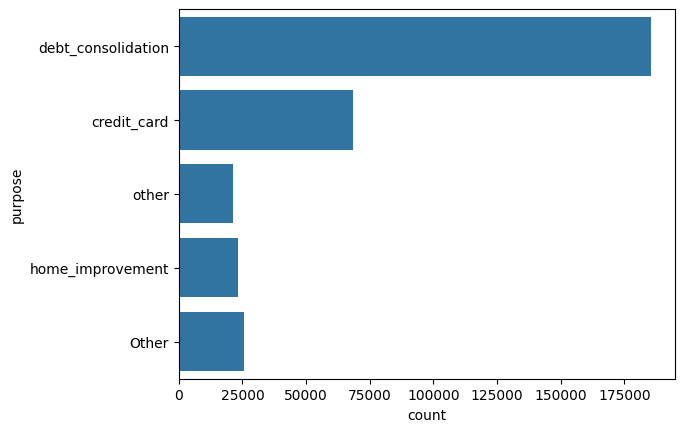

              purpose  percentage
0  debt_consolidation   57.201316
1         credit_card   21.082025
2               Other    7.956680
3    home_improvement    7.183585
4               other    6.576395


In [249]:
# inserting each purpose type that his percentage is lower than 2.5% to the other type
less_than_2_5_percent = purpose_percentages_df[purpose_percentages_df['percentage'] < 2.5]['purpose'].tolist()

expired_2019['purpose'] = expired_2019.apply(lambda x: 'Other' if x['purpose'] in less_than_2_5_percent else x['purpose'], axis=1)

purpose_counts = expired_2019['purpose'].value_counts()
purpose_percentages = purpose_counts * 100 / purpose_counts.sum()
purpose_percentages_df = pd.DataFrame({'purpose': purpose_counts.index, 'percentage': purpose_percentages.values})
purpose_percentages_df = purpose_percentages_df.sort_values(by='percentage', ascending=False)

#perform purpose distribution after formating
sns.countplot(expired_2019['purpose'])
plt.show()

print(purpose_percentages_df)


Droping the columns that were originally leakage but needed to compute the expected return

In [250]:

expired_2019.drop(columns=['last_pymnt_d', 'funded_amnt', 'Total_Months_Active'], axis=1, inplace=True)


Parcing and changing data types


In [251]:
# Make a copy of the DataFrame
expired_2019 = expired_2019.copy()

# Extracting the number out of the emp_length
expired_2019['emp_length']=expired_2019.emp_length.str.extract('(\d+)')
expired_2019['emp_length'] = expired_2019['emp_length'].astype(int)


# parse from the column 'term' in expired_2019 the word 'months' and convert it into int

expired_2019['term'] = expired_2019['term'].str.replace(' months', '')
expired_2019['term'] = expired_2019['term'].astype(int)

# # Removing the 'xx' from the zip_code column and changing the data type to int
# expired_2019['zip_code'] = expired_2019['zip_code'].str.replace('xx', '')
# expired_2019['zip_code'] = expired_2019['zip_code'].astype(int)

# # Removing the '%' sign from the revol_util column and changing the data type to double
# expired_2019['revol_util'] = expired_2019['revol_util'].str.replace('%', '')
# expired_2019['revol_util'] = expired_2019['revol_util'].astype(float)

# Removing the '%' sign from the int_rate column and changing the data type to double
expired_2019['int_rate'] = expired_2019['int_rate'].str.replace('%', '')
expired_2019['int_rate'] = expired_2019['int_rate'].astype(float)


# # Changing the 'Y' to 1 and the 'N' to 0 in the debt_settlement_flag column
# expired_2019['debt_settlement_flag'] = expired_2019['debt_settlement_flag'].apply(lambda x: 1 if x == 'Y' else 0)


In [252]:
# print the unique values of expired_2019['emp_length']

print(expired_2019['emp_length'].unique())


[ 9  5  6 10  1  0  8  3  4  2  7]


Non numerical Features after first formating :

In [253]:
# print the tittle of all the non numerical columns

non_numerical_cols = expired_2019.select_dtypes(include=['object']).columns
for col in non_numerical_cols:
    print(col)

grade
sub_grade
home_ownership
purpose
addr_state
earliest_cr_line
initial_list_status


In [254]:
# prompt: count how many unique values are in each of the non_numerical_cols

for col in non_numerical_cols:
  print(f"{col}: {expired_2019[col].nunique()}")


grade: 7
sub_grade: 35
home_ownership: 4
purpose: 5
addr_state: 50
earliest_cr_line: 660
initial_list_status: 2


Checking Features and data-types after ETL

###**encoding and High cardinality**


applying target encoding to the subgrade feature - no smooting was recommended via our find_best_smoothing fucntion


In [255]:


# Create the target encoder for the 'sub_grade' column without smoothing
encoder = ce.TargetEncoder(cols=['sub_grade'])

# Fit the encoder on the entire dataset
encoder.fit(expired_2019['sub_grade'], expired_2019['loan_status'])

# Transform the 'sub_grade' feature in the entire dataset
expired_2019['sub_grade_encoded'] = encoder.transform(expired_2019['sub_grade'])

# Reorder columns to place 'sub_grade_encoded' right next to 'sub_grade'
columns = list(expired_2019.columns)
sub_grade_index = columns.index('sub_grade')
columns.insert(sub_grade_index + 1, columns.pop(columns.index('sub_grade_encoded')))
expired_2019 = expired_2019[columns]





In [256]:
#omitting the subgrade column

expired_2019.drop(columns=['sub_grade'], axis=1, inplace=True)


encoding issue date_d (datetime type) which is the month of the year the loan was funded, into 4 quarters using one hot encoding

In [257]:
# Extract month and quarter
expired_2019['issue_quarter'] = expired_2019['issue_d'].dt.quarter
expired_2019 = pd.get_dummies(expired_2019, columns=['issue_quarter'], prefix='quarter')


In [258]:
expired_2019.drop(columns=['issue_d'], inplace=True)


engneer the earliest_cr_line into number of months since the earliest credit line was opened.

In [259]:
#Convert earliest_cr_line to DateTime:
expired_2019['earliest_cr_line'] = pd.to_datetime(expired_2019['earliest_cr_line'], format='%b-%y')

# Calculate the number of months since the earliest credit line
current_date = datetime.now()
expired_2019['earliest_cr_line_months'] = expired_2019['earliest_cr_line'].apply(lambda x: (current_date.year - x.year) * 12 + current_date.month - x.month)


Using ordinal encoding for the grade column

In [260]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

# Apply the mapping to the grade column
expired_2019['grade'] = expired_2019['grade'].map(grade_mapping)

# Ensure 'grade' is now an integer type
expired_2019['grade'] = expired_2019['grade'].astype(int)

expired_2019

,loan_amnt,term,int_rate,grade,sub_grade_encoded,emp_length,emp_status,home_ownership,annual_inc,loan_status,...,tax_liens,tot_hi_cred_lim,total_bc_limit,expected_return,yield_is_above_2,quarter_1,quarter_2,quarter_3,quarter_4,earliest_cr_line_months
0,9000.0,36,15.31,3,0.282400,9,1,RENT,52000.0,0,...,0.0,58425.0,15900.0,0.840506,0,True,False,False,False,294
2,8000.0,36,10.75,2,0.167067,5,1,RENT,73000.0,0,...,0.0,78840.0,22000.0,0.551224,0,True,False,False,False,232
3,12800.0,36,11.99,3,0.209314,6,1,MORTGAGE,53000.0,0,...,0.0,235600.0,7900.0,0.770965,0,True,False,False,False,266
4,5000.0,36,16.29,4,0.308556,10,1,MORTGAGE,105000.0,1,...,0.0,496358.0,5600.0,0.839345,1,True,False,False,False,227
5,24000.0,36,9.75,2,0.140690,5,1,MORTGAGE,50000.0,1,...,0.0,113715.0,20000.0,0.300651,1,True,False,False,False,369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103538,32000.0,60,14.49,3,0.272511,3,1,MORTGAGE,157000.0,1,...,0.0,524379.0,15800.0,-1.411776,1,False,False,False,True,155
103539,16000.0,60,12.79,3,0.209314,10,1,RENT,150000.0,0,...,0.0,87473.0,10100.0,0.825258,0,False,False,False,True,321
103541,24000.0,60,12.79,3,0.209314,7,1,MORTGAGE,95000.0,0,...,0.0,102517.0,0.0,0.811817,0,False,False,False,True,293
103543,40000.0,60,10.49,2,0.140690,9,1,MORTGAGE,227000.0,0,...,0.0,55970.0,12300.0,0.575703,0,False,False,False,True,351


high cardinality in 'addr_state'  dividing the states into 5 (still need to be investigated) clusters (10 in each) based on median household income data. 1 is the highest median 5 is the lowest. we're still not shure if we'll use this feature.


In [261]:
# # dividing the states into 5 clusters (10 in each) based on median household income data. 1 is the highest median 5 is the lowest

# def create_state_income_cluster(df):
#   """
#   Creates a new column representing state-household income cluster.

#   Args:
#       df: DataFrame containing the data.

#   Returns:
#       DataFrame with the new column.
#   """

#   # Define the clusters
#   cluster1 = ['NJ', 'MD', 'MA', 'HI', 'CA', 'WA', 'NH', 'CO', 'UT', 'CT']
#   cluster2 = ['AK', 'VA', 'MN', 'DE', 'RI', 'NY', 'IL', 'OR', 'AZ', 'VT']
#   cluster3 = ['GA', 'ID', 'NV', 'TX', 'ND', 'PA', 'WI', 'WY', 'SD', 'NE']
#   cluster4 = ['IA', 'ME', 'FL', 'KS', 'MT', 'NC', 'MI', 'IN', 'OH', 'TN']
#   cluster5 = ['MO', 'SC', 'NM', 'AL', 'OK', 'KY', 'AR', 'LA', 'WV', 'MS']

#   # Create a new column based on the clusters
#   df['StateIncomeCluster'] = df['addr_state'].apply(lambda state:
#                                                    1 if state in cluster1 else
#                                                    2 if state in cluster2 else
#                                                    3 if state in cluster3 else
#                                                    4 if state in cluster4 else
#                                                    5)

#   return df

# # Apply the function to the DataFrame
# expired_2019 = create_state_income_cluster(expired_2019)

expired_2019.drop(columns=['addr_state'], axis=1, inplace=True)



one hot encoding, for the rest of the non-numeric features

In [262]:
# One-hot encoding for categorical features
categorical_features = ['home_ownership', 'purpose', 'initial_list_status']
expired_2019 = pd.get_dummies(expired_2019, columns=categorical_features)

# Display the resulting DataFrame
print("DataFrame after one-hot encoding:")
print(expired_2019.head())


DataFrame after one-hot encoding:
   loan_amnt  term  int_rate  grade  sub_grade_encoded  emp_length  \
0     9000.0    36     15.31      3           0.282400           9   
2     8000.0    36     10.75      2           0.167067           5   
3    12800.0    36     11.99      3           0.209314           6   
4     5000.0    36     16.29      4           0.308556          10   
5    24000.0    36      9.75      2           0.140690           5   

   emp_status  annual_inc  loan_status    dti  ...  home_ownership_MORTGAGE  \
0           1     52000.0            0  18.86  ...                    False   
2           1     73000.0            0  10.85  ...                    False   
3           1     53000.0            0  20.99  ...                     True   
4           1    105000.0            1   9.07  ...                     True   
5           1     50000.0            1  24.46  ...                     True   

  home_ownership_OWN  home_ownership_RENT  purpose_Other  purpose_cred

In [263]:

print(f"Number of remaining instances: {len(expired_2019)}")
print("Remaining features:")
count = 1
for column_name in expired_2019.columns:
  print(f"{count}- {column_name}")
  count+=1


Number of remaining instances: 324281
Remaining features:
1- loan_amnt
2- term
3- int_rate
4- grade
5- sub_grade_encoded
6- emp_length
7- emp_status
8- annual_inc
9- loan_status
10- dti
11- delinq_2yrs
12- earliest_cr_line
13- fico_range_low
14- open_acc
15- pub_rec
16- revol_bal
17- revol_util
18- total_acc
19- open_act_il
20- il_util
21- max_bal_bc
22- all_util
23- total_rev_hi_lim
24- total_cu_tl
25- acc_open_past_24mths
26- avg_cur_bal
27- bc_open_to_buy
28- bc_util
29- delinq_amnt
30- mo_sin_old_rev_tl_op
31- mo_sin_rcnt_rev_tl_op
32- mo_sin_rcnt_tl
33- mort_acc
34- num_accts_ever_120_pd
35- num_actv_bc_tl
36- num_actv_rev_tl
37- num_bc_sats
38- num_bc_tl
39- num_il_tl
40- num_op_rev_tl
41- num_rev_accts
42- num_tl_30dpd
43- num_tl_90g_dpd_24m
44- num_tl_op_past_12m
45- pct_tl_nvr_dlq
46- pub_rec_bankruptcies
47- tax_liens
48- tot_hi_cred_lim
49- total_bc_limit
50- expected_return
51- yield_is_above_2
52- quarter_1
53- quarter_2
54- quarter_3
55- quarter_4
56- earliest_cr_line_mon

###**relative entropy-based filtering** to identify and remove low-information features.

In [264]:

# Function to calculate normalized entropy
def calculate_normalized_entropy(column):
    counts = column.value_counts()
    raw_entropy = entropy(counts)
    max_entropy = np.log(len(counts))
    normalized_entropy = raw_entropy / max_entropy if max_entropy > 0 else 0
    return normalized_entropy

normalized_entropies = expired_2019.apply(calculate_normalized_entropy)


features_count = 1
for feature in expired_2019.columns:
  print(f"{features_count}: {feature} - Entropy: {calculate_normalized_entropy(expired_2019[feature])}")
  features_count += 1


1: loan_amnt - Entropy: 0.6422046512154329
2: term - Entropy: 0.7069393217087065
3: int_rate - Entropy: 0.8317491592739009
4: grade - Entropy: 0.8129143019039291
5: sub_grade_encoded - Entropy: 0.8931765294105651
6: emp_length - Entropy: 0.8738167307188913
7: emp_status - Entropy: 0.3456363464008259
8: annual_inc - Entropy: 0.5651733810660429
9: loan_status - Entropy: 0.7521549598976796
10: dti - Entropy: 0.9594639051141817
11: delinq_2yrs - Entropy: 0.23450536609519554
12: earliest_cr_line - Entropy: 0.8956765759421776
13: fico_range_low - Entropy: 0.825308506792022
14: open_acc - Entropy: 0.716844730870601
15: pub_rec - Entropy: 0.1849128601825766
16: revol_bal - Entropy: 0.9560583314230621
17: revol_util - Entropy: 0.9685523023550409
18: total_acc - Entropy: 0.7951381690272454
19: open_act_il - Entropy: 0.5495027296367979
20: il_util - Entropy: 0.49677507642149
21: max_bal_bc - Entropy: 0.931681232578096
22: all_util - Entropy: 0.8648314214753592
23: total_rev_hi_lim - Entropy: 0.74

In [265]:
# omitting features with entropy lower than 0.07

threshold = 0.1

# Identify features to remove
features_to_remove = normalized_entropies[normalized_entropies < threshold].index.tolist()

# Print the names of the omitted features
print("Features with low information (entropy < 0.1):")
for feature in features_to_remove:
    print(f"- {feature}")

# Remove the features with low information from the DataFrame
expired_2019 = expired_2019.drop(features_to_remove, axis=1)




Features with low information (entropy < 0.1):
- delinq_amnt
- num_tl_30dpd
- num_tl_90g_dpd_24m
- tax_liens
- home_ownership_ANY


### **Outliers Detection and Removal**

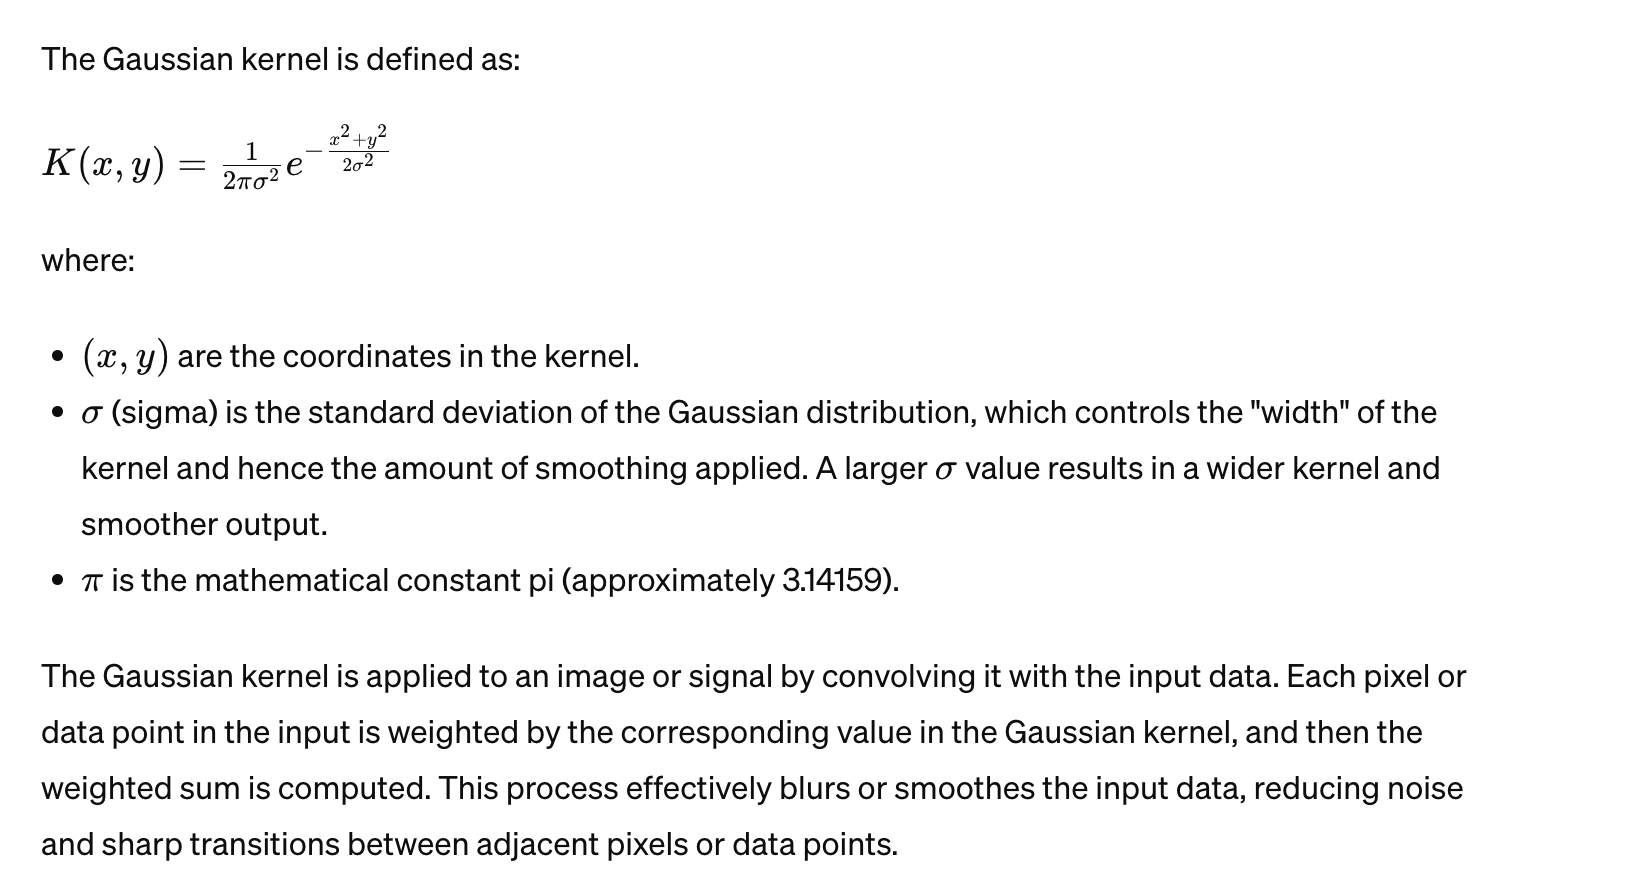



 The function **remove_outliers_gaussia** (found in the helper functions section) effectively removes outliers from a specified feature in a DataFrame using a Gaussian kernel approach. By calculating the mean and standard deviation of the feature, it defines bounds for outlier detection. Employing the Gaussian kernel method, it creates a mask to identify outliers, subsequently filtering the DataFrame to exclude these data points.The function plots boxplots of the feature's distribution before and after outlier removal, providing visual insights. Additionally, it prints the number of instances removed, facilitating a quantitative understanding of the impact of outlier removal. Overall, this function offers a concise and comprehensive solution for outlier removal in data analysis tasks.

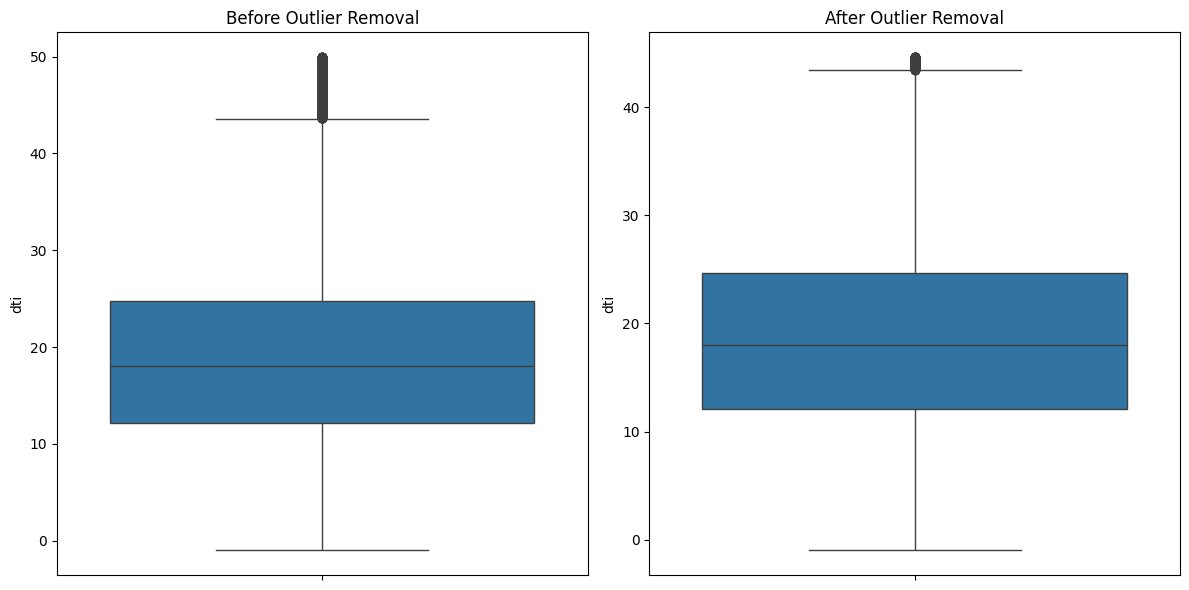

Number of instances removed: 883
Number of instances removed: 0
Number of instances removed: 23
Number of instances removed: 395


In [266]:
# We decided for now not to use this method
# percentile_trim(expired_2019, 'annual_inc', threshold_low=5, threshold_high=95)
# percentile_trim(expired_2019, 'loan_amnt', threshold_low=5, threshold_high=95)
# percentile_trim(expired_2019, 'int_rate', threshold_low=5, threshold_high=95)

#change parameter , plot=True to see the box plot distribution of the rest of features
expired_2019 = remove_outliers_gaussian(expired_2019, 'dti')
expired_2019 = remove_outliers_gaussian(expired_2019, 'loan_amnt', plot=False)
expired_2019 = remove_outliers_gaussian(expired_2019, 'revol_util', plot=False)
expired_2019 = remove_outliers_gaussian(expired_2019, 'all_util', plot=False)



We will apply log transformation to specific features with non-normal distributions to provide a slightly smoother distriution and minimize bias while keeping the values possition.

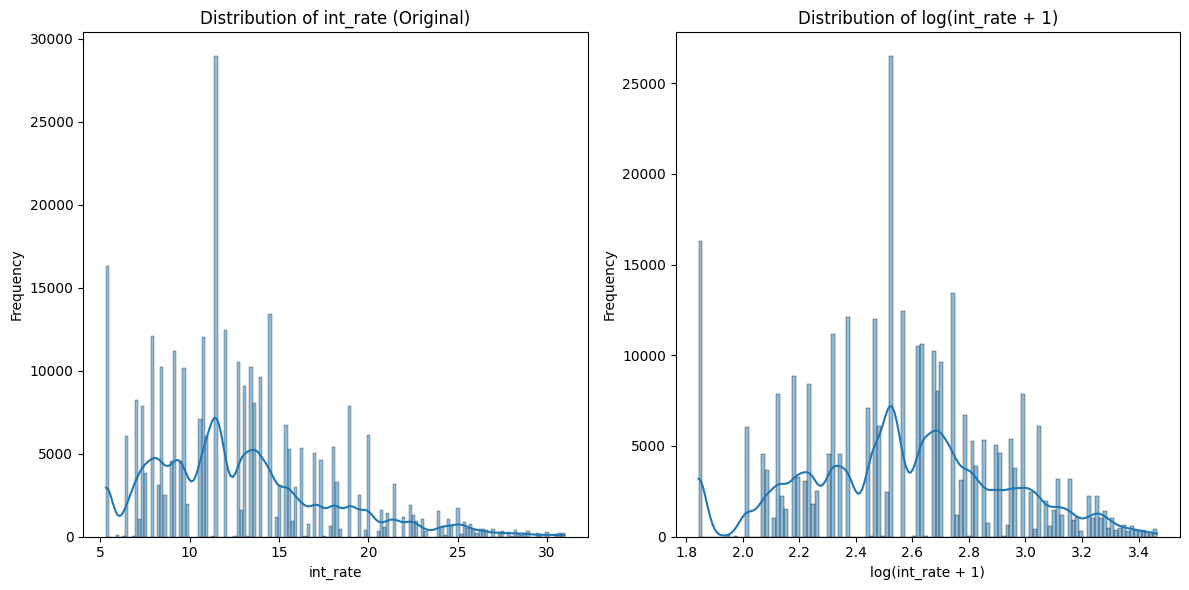

In [267]:
# Example
plot_distribution_with_log(expired_2019, 'int_rate')

# Implementation
features_to_transform = ['annual_inc', 'revol_bal', 'max_bal_bc','int_rate']
for feature in features_to_transform:
    expired_2019[feature] = np.log1p(expired_2019[feature])

In [268]:
# prompt: please print number of remaining instances in expired 2019 data frame, and below print "remaining features" and
# the names of the remaning features in expired_2019 using for loop with indexing starting from 1.

print(f"Number of remaining instances: {len(expired_2019)}")
print("Remaining features:")
count = 1
for column_name in expired_2019.columns:
  print(f"{count}- {column_name}")
  count+=1


Number of remaining instances: 322980
Remaining features:
1- loan_amnt
2- term
3- int_rate
4- grade
5- sub_grade_encoded
6- emp_length
7- emp_status
8- annual_inc
9- loan_status
10- dti
11- delinq_2yrs
12- earliest_cr_line
13- fico_range_low
14- open_acc
15- pub_rec
16- revol_bal
17- revol_util
18- total_acc
19- open_act_il
20- il_util
21- max_bal_bc
22- all_util
23- total_rev_hi_lim
24- total_cu_tl
25- acc_open_past_24mths
26- avg_cur_bal
27- bc_open_to_buy
28- bc_util
29- mo_sin_old_rev_tl_op
30- mo_sin_rcnt_rev_tl_op
31- mo_sin_rcnt_tl
32- mort_acc
33- num_accts_ever_120_pd
34- num_actv_bc_tl
35- num_actv_rev_tl
36- num_bc_sats
37- num_bc_tl
38- num_il_tl
39- num_op_rev_tl
40- num_rev_accts
41- num_tl_op_past_12m
42- pct_tl_nvr_dlq
43- pub_rec_bankruptcies
44- tot_hi_cred_lim
45- total_bc_limit
46- expected_return
47- yield_is_above_2
48- quarter_1
49- quarter_2
50- quarter_3
51- quarter_4
52- earliest_cr_line_months
53- home_ownership_MORTGAGE
54- home_ownership_OWN
55- home_owners

In [269]:
#  all the not numeric features remaining in expired_2019

object_cols = [col for col in expired_2019.columns if expired_2019[col].dtype == 'object']

for col in object_cols:
  print(col)


In [270]:
# shape of expired_2019

print(expired_2019.shape)


(322980, 62)


# **Normalization:**

In [271]:
numeric_columns = expired_2019.select_dtypes(include=['float64', 'int64']).columns

# Create the MinMaxScaler instance
min_max_scaler = MinMaxScaler()

# Fit and transform the data
expired_2019[numeric_columns] = min_max_scaler.fit_transform(expired_2019[numeric_columns])

# Display the resulting DataFrame
print("DataFrame after Min-Max scaling:")
print(expired_2019.head())
